# Analysis of 2018-01-12-HWCT5AFXX with Salmon

Protocol modified by Daniel. This time including AlkB. Need to find out other details

**Here I use transcript-level quantification (Salmon) to estimate tRNA levels** I would like to also quantify using methods from https://www.biorxiv.org/content/early/2018/01/11/246967 "Limitation of alignment-free tools in total RNA-seq quantification" since they noted tRNA quantification problems with Salmon

<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle code on/off."></form>

In [58]:
suppressMessages({
    .libPaths(c("/g/steinmetz/brooks/anaconda/envs/genphen/lib/R/library",
                "/g/steinmetz/brooks/anaconda/lib/R/library",
               "/root/anaconda3/envs/jupyter/lib/R/library"))
    # config opts and libraries
    options(repr.plot.width = 6)
    options(repr.plot.height = 5)
    options(jupyter.plot_mimetypes = 'image/png')
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/R-tools/master/defaultRlibs.R")
    devtools::source_url("https://raw.githubusercontent.com/scalefreegan/steinmetz-lab/master/yeast2_0/scripts/seqtools.R")
    library(wasabi)
    library(sleuth)
    library(pheatmap)
    library(forcats)
})

In [59]:
# load ncRNA annotations
load("/g/steinmetz/project/IESY/trna/data/ncRNA_annotations.rda")

In [60]:
sample2ezname = function(x) {
    o = x
    o[x == "S1"] = "neo_alkb"
    o[x == "S2"] = "prs_alkb"
    o[x == "S3"] = "js613_alkb"
    o[x == "S4"] = "neo"
    o[x == "S5"] = "prs"
    o[x == "S6"] = "js613"
    return(o)
}
chr2ezname = function(x) {
    o = x
    o[x == "chr17"] = "mito"
    o[x == "chr18"] = "neo"
    return(o)
}
RESULTS = "/g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon"
S1 = read_tsv(file.path(RESULTS, "Sample1/quant.sf"), col_names = T) %>% 
    mutate(sample = "S1")
S2 = read_tsv(file.path(RESULTS, "Sample2/quant.sf"), col_names = T) %>% 
    mutate(sample = "S2")
S3 = read_tsv(file.path(RESULTS, "Sample3/quant.sf"), col_names = T) %>% 
    mutate(sample = "S3")
S4 = read_tsv(file.path(RESULTS, "Sample4/quant.sf"), col_names = T) %>% 
    mutate(sample = "S4")
S5 = read_tsv(file.path(RESULTS, "Sample5/quant.sf"), col_names = T) %>% 
    mutate(sample = "S5")
S6 = read_tsv(file.path(RESULTS, "Sample6/quant.sf"), col_names = T) %>% 
    mutate(sample = "S6")
results = bind_rows(S1, S2, S3, S4, S5, S6)
results$Name.original = results$Name
results = results %>% separate(Name, into = c("origin","Name"),sep = "\\.", extra = "merge", remove = T)
# because of naming, I need to move to mtrans
mtrnas = which(is.na(results$Name))
if (length(mtrnas) > 0) {
    results$Name[mtrnas] = results$origin[mtrnas]
    results$origin[mtrnas] = NA
} 
# combine with ncRNA annotations
results = merge(results, allncrnas, by = c("Name","origin"))
results = results %>% separate(Name, into = c("tmp1","tmp2"), sep = "-", extra = "merge", remove = F) %>%
    separate(tmp2, into = c("AA","Isotype"), sep = 3, remove = T) %>%
    separate(Isotype, into = c("Isotype","Isotype.Number"), sep = 3, remove = T) %>%
    mutate(mature.trna = ifelse(grepl("tRNA", Name) & !grepl("chr", Name),T,F))
results = results %>% mutate(ezseqid = chr2ezname(seqid), ezsample = sample2ezname(sample))
results$tmp1 = NULL
# sep out strain and treatment
results = results %>% separate(ezsample, into = c("strain","treatment"), sep = "_", remove = F)
results = results %>% mutate(treatment = ifelse(grepl("alkb",treatment),T,F))

Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_double(),
  TPM = col_double(),
  NumReads = col_double()
)
Parsed with column specification:
cols(
  Name = col_character(),
  Length = col_integer(),
  EffectiveLength = col_doub

In [4]:
aggresults = acast(results %>% filter(grepl("mature_tRNA",type)), formula = Name ~ sample, value.var = "NumReads", fun.aggregate = median) 
aggresults = log2(aggresults + 1)
colnames(aggresults) = sample2ezname(colnames(aggresults))

# Figure 1: ncRNA TPM reproducibility across samples

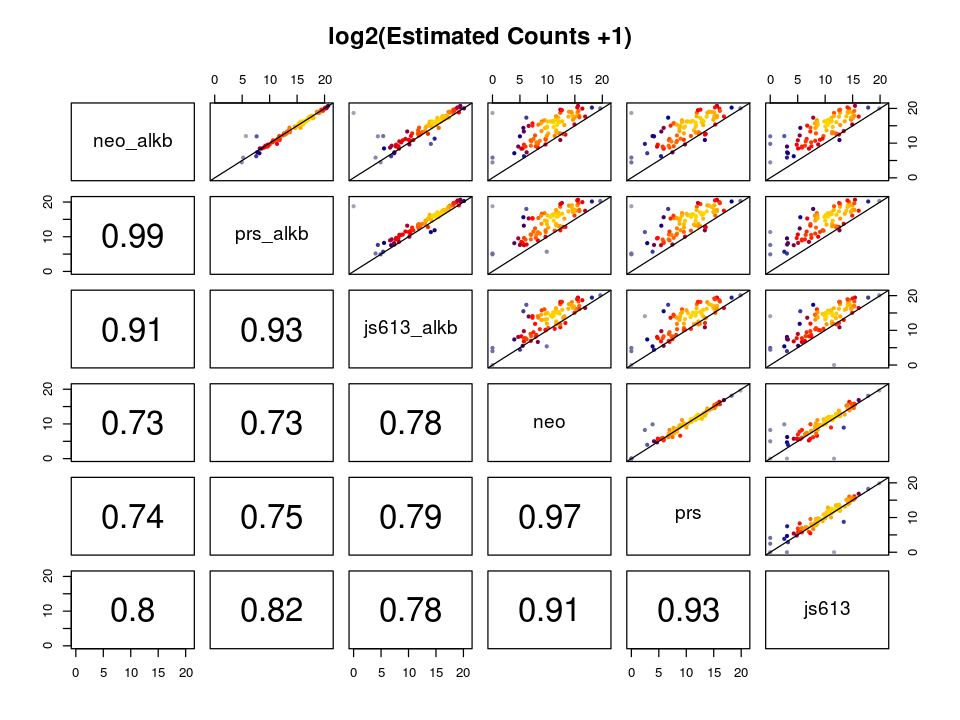

In [5]:
options(repr.plot.width = 8)
options(repr.plot.height = 6)
LSD::heatpairs(aggresults, main = "log2(Estimated Counts +1)")

# Figure 2: ncRNA expression across all chromosomes

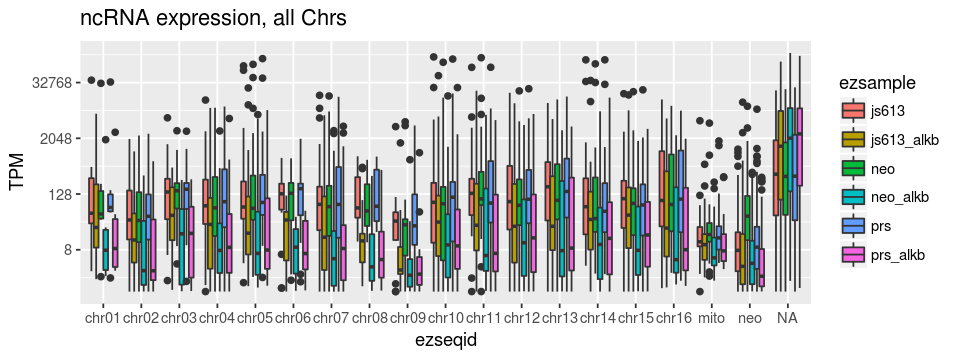

In [6]:
options(repr.plot.width = 8)
options(repr.plot.height = 3)
p2 <- ggplot(results) +
    geom_boxplot(aes(ezseqid, TPM+1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("ncRNA expression, all Chrs") + ylab("TPM")
p2

# Figure 3: pre-tRNA expression across all chromosomes

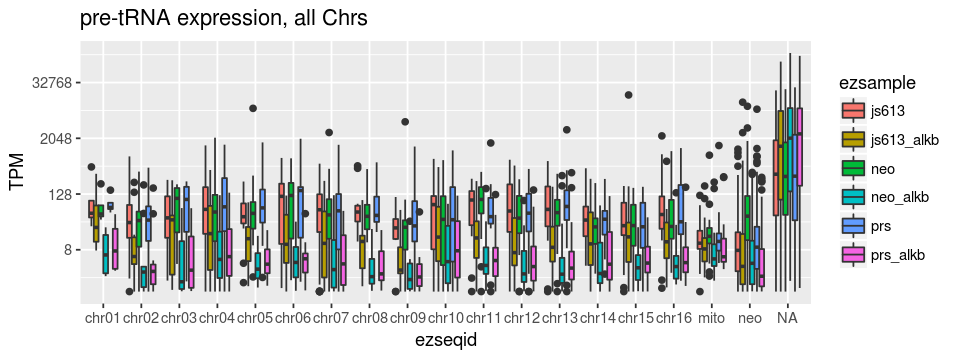

In [7]:
p3 <- ggplot(results %>% filter(grepl("tRNA",Name))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM")
p3

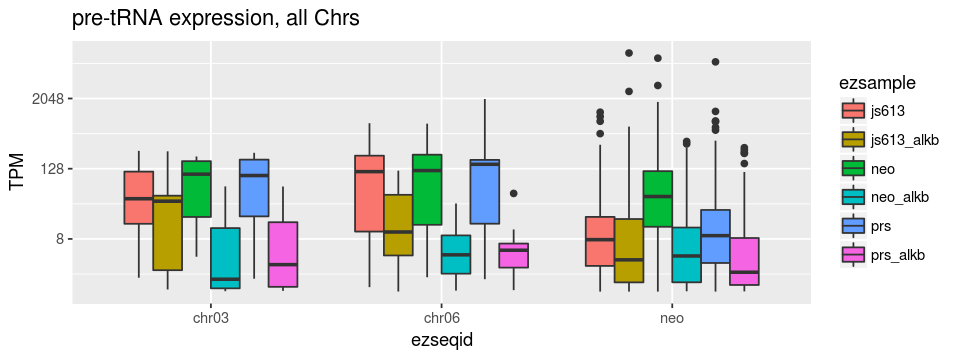

In [8]:
p3.2 <- ggplot(results %>% filter(grepl("tRNA",Name),ezseqid %in% c("chr03","chr06","neo"))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("pre-tRNA expression, all Chrs") + ylab("TPM")
p3.2

# Figure 4: ncRNA (non-tRNA) expression across all chromosomes

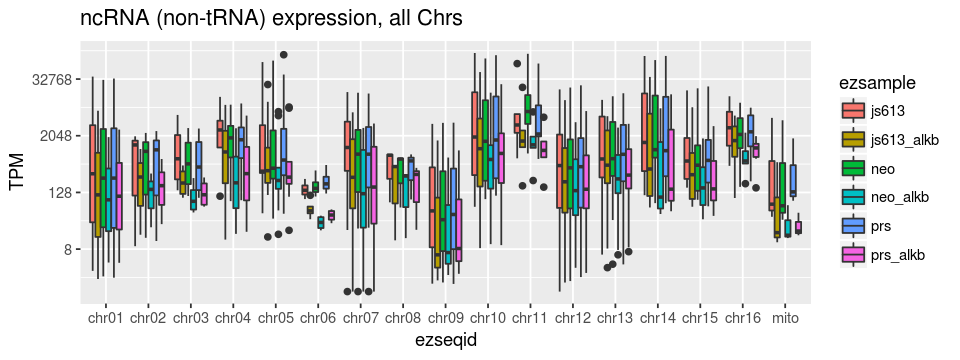

In [9]:
p4 <- ggplot(results %>% filter(!grepl("tRNA",Name))) +
    geom_boxplot(aes(ezseqid, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
    ggtitle("ncRNA (non-tRNA) expression, all Chrs") + ylab("TPM")
p4

# Figure 5: mature-tRNA by amino acid

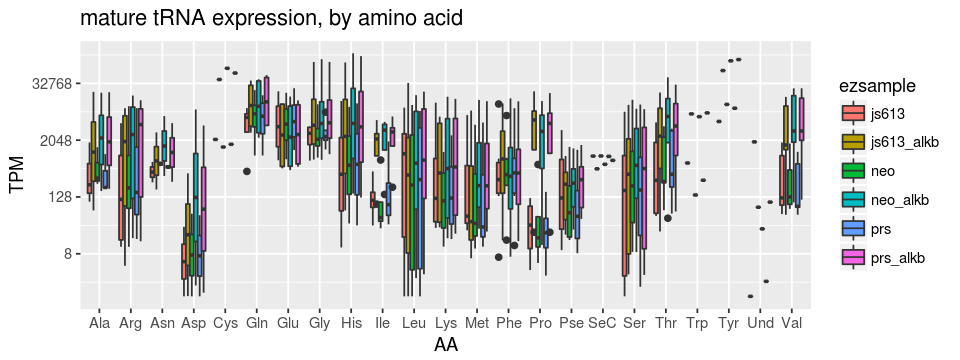

In [10]:
p5 <- ggplot(results %>% filter(mature.trna)) +
    geom_boxplot(aes(AA, TPM + 1, fill = ezsample)) + scale_y_continuous(trans="log2") +
     ggtitle("mature tRNA expression, by amino acid") + ylab("TPM")
p5

# Differential Analysis by sleuth

Prepare directories using wasabi

In [65]:
sr = file.path(RESULTS,"sleuth_results.rda")
sr2 = file.path(RESULTS,"sleuth_results_noalkb.rda")
rerun = F
if (!file.exists(sr) | rerun) {
    cat("Running sleuth\n\n")
    salmondirs <- file.path(RESULTS, c("Sample1",
                                       "Sample2",
                                       "Sample3",
                                       "Sample4",
                                       "Sample5",
                                       "Sample6"))
    for (i in salmondirs) {
        if (file.exists(file.path(i,"abundance.h5"))) {
            file.remove(file.path(i,"abundance.h5"))
        }
    }
    
    prepare_fish_for_sleuth(salmondirs)
    synT = data.frame(
        sample = c("neo_alkb", "prs_alkb", "js613_alkb", "neo", "prs", "js613"),
        condition1 = c("wt", "wt", "syn", "wt", "wt", "syn"),
        condition2 = c("neo+", "neo-", "neo-", "neo+", "neo-", "neo-"),
        condition3 = c("alkb", "alkb", "alkb", "none", "none", "none"),
        path = c(
                file.path(RESULTS, c("Sample1")),
                file.path(RESULTS, c("Sample2")),
                file.path(RESULTS, c("Sample3")),
                file.path(RESULTS, c("Sample4")),
                file.path(RESULTS, c("Sample5")),
                file.path(RESULTS, c("Sample6"))),
        stringsAsFactors = F
    )
    so <- sleuth_prep(synT, ~ condition1 + condition2 + condition3)
    so <- sleuth_fit(so)
    so <- sleuth_fit(so, ~1, 'reduced')
    so <- sleuth_lrt(so, 'reduced', 'full')
    results_table <- sleuth_results(so, 'reduced:full', test_type = 'lrt')
    save(so, results_table, file = sr)
    # without alkb
    synT_noalkb = data.frame(
        sample = c("neo", "prs", "js613"),
        #condition1 = c("wt", "wt", "syn"),
        condition2 = c("neo+", "neo-", "neo-"),
        path = c(
                file.path(RESULTS, c("Sample4")),
                file.path(RESULTS, c("Sample5")),
                file.path(RESULTS, c("Sample6"))),
        stringsAsFactors = F
    )
    so_noalkb <- sleuth_prep(synT_noalkb, ~ condition2)
    so_noalkb <- sleuth_fit(so_noalkb)
    so_noalkb <- sleuth_fit(so_noalkb, ~1, 'reduced')
    so_noalkb <- sleuth_lrt(so_noalkb, 'reduced', 'full')
    results_table_noalkb <- sleuth_results(so_noalkb, 'reduced:full', test_type = 'lrt')
    save(so_noalkb, results_table_noalkb, file = sr2)
} else {
    load(sr)
    load(sr2)
}

Running sleuth

Tue Mar 20 17:13:21 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon/Sample1 to kallisto HDF5 format"
Tue Mar 20 17:13:23 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon/Sample2 to kallisto HDF5 format"
Tue Mar 20 17:13:24 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon/Sample3 to kallisto HDF5 format"
Tue Mar 20 17:13:26 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon/Sample4 to kallisto HDF5 format"
Tue Mar 20 17:13:28 2018
[1] "Successfully converted sailfish / salmon results in /g/steinmetz/project/IESY/trna/results/2018-01-12-HWCT5AFXX/results/salmon/Sample5 to kallisto HDF5 format"
Tue Mar 20 17:13:30 2018
[1] "Succ

reading in kallisto results
dropping unused factor levels
......
normalizing est_counts
662 targets passed the filter
normalizing tpm
merging in metadata
summarizing bootstraps

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas
reading in kallisto results
dropping unused factor levels
...
normalizing est_counts
652 targets passed the filter
normalizing tpm
merging in metadata
summarizing bootstraps

fitting measurement error models
shrinkage estimation
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


In [66]:
results_table_noalkb

target_id,test_stat,pval,qval,rss,sigma_sq,tech_var,mean_obs,var_obs,sigma_sq_pmax,smooth_sigma_sq,final_sigma_sq,degrees_free
SYN.chr18.tRNA70-ValCAC,9.940485,0.0016168293,0.1501342,2.23921086,1.08609046,3.351497e-02,4.495344,1.11960543,1.08609046,0.11879288,1.08609046,1
SYN.chr18.tRNA48-PheGAA,10.317069,0.0013180542,0.1501342,7.16705553,3.41560203,1.679257e-01,4.422286,3.58352777,3.41560203,0.12266854,3.41560203,1
SYN.chr18.tRNA176-ProTGG,11.408723,0.0007310005,0.1501342,7.42381242,3.59965954,1.122467e-01,4.653413,3.71190621,3.59965954,0.11784858,3.59965954,1
SYN.chr18.tRNA20-TyrGTA,10.206560,0.0013994194,0.1501342,4.30008239,2.08173303,6.830817e-02,5.025628,2.15004119,2.08173303,0.12410593,2.08173303,1
SYN.chr18.tRNA6-GlyGCC,11.766812,0.0006029615,0.1501342,5.36676294,2.62726269,5.611878e-02,4.722131,2.68338147,2.62726269,0.11933916,2.62726269,1
SYN.chr18.tRNA99-ProTGG,10.666986,0.0010906471,0.1501342,5.45977358,2.68324053,4.664626e-02,4.349629,2.72988679,2.68324053,0.12968017,2.68324053,1
tRNA-SerAGA1,10.520307,0.0011806985,0.1501342,14.01024120,6.90250754,1.026131e-01,3.721835,7.00512060,6.90250754,0.26290819,6.90250754,1
SYN.chr18.tRNA42-LeuGAG,9.254653,0.0023489782,0.1908545,8.45474485,3.96226398,2.651084e-01,4.364513,4.22737243,3.96226398,0.12799507,3.96226398,1
SYN.chr18.tRNA23-AlaAGC,8.411232,0.0037290983,0.2049051,2.62922812,1.25627491,5.833915e-02,3.776836,1.31461406,1.25627491,0.24533673,1.25627491,1
SYN.chr18.tRNA25-ThrAGT,7.138032,0.0075465939,0.2049051,2.32956550,1.05078596,1.139968e-01,4.271018,1.16478275,1.05078596,0.13950779,1.05078596,1


In [62]:
rf2 = file.path(RESULTS,"all_results_noalkb.rds")
rerun = F
if (!file.exists(rf2) | rerun) {
    cat("Merging and saving\n")
    results_noalkb = merge(results, results_table_noalkb, by.x = "Name.original", by.y = "target_id", all.x = T)
    results_noalkb$type[grepl("tRNA",results_noalkb$Name)] = "mature_tRNA"
    results_noalkb$type[grepl("chr.*tRNA",results_noalkb$Name)] = "pre_tRNA"
    results_noalkb$type[grepl("snoRNA_gene",results_noalkb$type)] = "snoRNA"
    results_noalkb$type[grepl("ncRNA_gene",results_noalkb$type)] = "ncRNA_other"
    results_noalkb$type[grepl("snRNA_gene",results_noalkb$type)] = "snRNA"
    results_noalkb$type[grepl("rRNA_gene",results_noalkb$type)] = "rRNA"
    results_noalkb$ezseqid[which(results_noalkb$type=="mature_tRNA")] = "mature"
    saveRDS(results_noalkb, rf2)
} else {
    results_noalkb <- readRDS(rf2)
}

rf = file.path(RESULTS,"all_results.rds")
rerun = F
if (!file.exists(rf) | rerun) {
    cat("Merging and saving\n")
    results = merge(results, results_table, by.x = "Name.original", by.y = "target_id", all.x = T)
    results$type[grepl("tRNA",results$Name)] = "mature_tRNA"
    results$type[grepl("chr.*tRNA",results$Name)] = "pre_tRNA"
    results$type[grepl("snoRNA_gene",results$type)] = "snoRNA"
    results$type[grepl("ncRNA_gene",results$type)] = "ncRNA_other"
    results$type[grepl("snRNA_gene",results$type)] = "snRNA"
    results$type[grepl("rRNA_gene",results$type)] = "rRNA"
    results$ezseqid[which(results$type=="mature_tRNA")] = "mature"
    saveRDS(results, rf)
} else {
    results <- readRDS(rf)
}

In [63]:
#head(results)
#head(results_table, 21)
results %>% select(Name.original, qval) %>% distinct() %>% 
    summarise(n.sig.01 = sum(qval<.01, na.rm=T),
             n.sig.05 = sum(qval<.05, na.rm=T),
             n.sig.1 = sum(qval<.1, na.rm=T))

n.sig.01,n.sig.05,n.sig.1
192,404,471


In [64]:
results_noalkb %>% select(Name.original, qval) %>% distinct() %>% 
    summarise(n.sig.01 = sum(qval<.01, na.rm=T),
             n.sig.05 = sum(qval<.05, na.rm=T),
             n.sig.1 = sum(qval<.1, na.rm=T))

n.sig.01,n.sig.05,n.sig.1
0,0,0


# Figure 6: tRNAs with sig different expression levels by chr

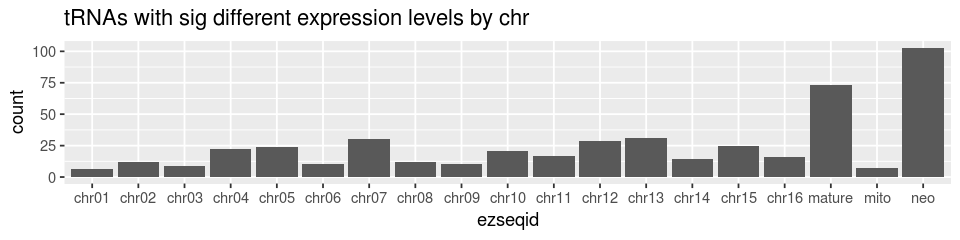

In [17]:
options(repr.plot.width = 8)
options(repr.plot.height = 2)
p6 <- ggplot(filter(results,qval<=.1) %>% select(Name,ezseqid) %>% distinct()) + geom_bar(aes(ezseqid)) +
    ggtitle("tRNAs with sig different expression levels by chr")
p6

# Figure 7: Composition of reads (TPMs) by type

In [18]:
results %>% arrange(-TPM) %>% head()

Name.original,Name,AA,Isotype,Isotype.Number,origin,Length,EffectiveLength,TPM,NumReads,⋯,qval,rss,sigma_sq,tech_var,mean_obs,var_obs,sigma_sq_pmax,smooth_sigma_sq,final_sigma_sq,degrees_free
tRNA-HisGTG1,tRNA-HisGTG1,His,GTG,1,NA,76,34,142389.8,1758327.7,⋯,0.0008330209,9.4264009,1.88526931,1.088218e-05,12.40941,1.88528019,1.88526931,0.3340086,1.8852693,3
tRNA-HisGTG1,tRNA-HisGTG1,His,GTG,1,NA,76,35,123605.0,1643152.7,⋯,0.0008330209,9.4264009,1.88526931,1.088218e-05,12.40941,1.88528019,1.88526931,0.3340086,1.8852693,3
WT.snR128,snR128,NA,NA,NA,WT,126,39,117173.6,394061.9,⋯,0.0026327291,1.8032879,0.36065517,2.406523e-06,12.85419,0.36065758,0.36065517,0.3754670,0.3754670,3
WT.snR64,snR64,NA,NA,NA,WT,101,40,112631.2,448029.0,⋯,0.0031995542,2.0157933,0.40315457,4.091736e-06,12.49826,0.40315866,0.40315457,0.3415693,0.4031546,3
WT.snR67,snR67,NA,NA,NA,WT,82,40,107752.7,448979.4,⋯,0.0098540723,2.9851770,0.59703141,3.993468e-06,12.48392,0.59703540,0.59703141,0.3403258,0.5970314,3
tRNA-GlyGCC1,tRNA-GlyGCC1,Gly,GCC,1,NA,74,32,106472.7,1237457.6,⋯,0.0026853914,0.4381777,0.08763328,2.251864e-06,13.17169,0.08763553,0.08763328,0.4111274,0.4111274,3


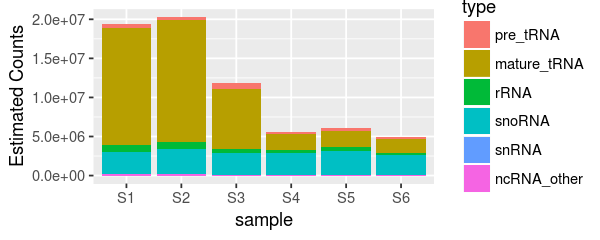

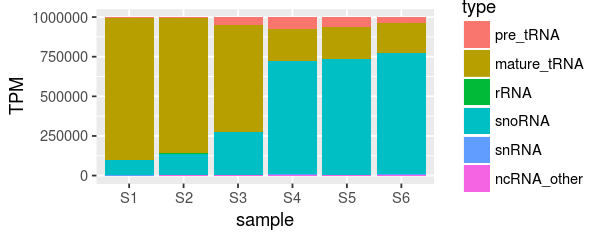

In [21]:
options(repr.plot.width = 5)
options(repr.plot.height = 2)
results$type = factor(results$type, levels = (c(
"pre_tRNA",
"mature_tRNA",
"rRNA",
"snoRNA",
"snRNA",
"ncRNA_other")))
p7 <- ggplot(results %>% group_by(type, sample) %>% summarise(sum=sum(NumReads))) + 
geom_bar(aes(y = sum, x = sample, 
    fill = type), stat = "identity") +
    ylab("Estimated Counts")
p7
p7.2 <- ggplot(results %>% group_by(type, sample) %>% summarise(sum=sum(TPM))) + 
geom_bar(aes(y = sum, x = sample, 
    fill = type), stat = "identity") +
    ylab("TPM")
p7.2

## What's up with TPM??

Notice how the estimated count and TPM dists are totally different. The rRNA fraction goes from quite high to almost non-existant. Weird. Also Basti pointed out from FASTQC file that the 5.8S rRNA accounts for 30-40% of these libraries. 

In [22]:
filter(results,grepl("RDN58",Name.original)) %>% select(Name,Length,EffectiveLength,TPM,NumReads)

Name,Length,EffectiveLength,TPM,NumReads
RDN58-1,158,824.699,86.32139,7415.698
RDN58-1,158,718.822,35.46951,5676.498
RDN58-1,158,766.501,76.92436,5084.482
RDN58-1,158,512.129,46.68485,9080.908
RDN58-1,158,751.058,82.31651,6148.195
RDN58-1,158,613.046,35.61459,7929.808


In Salmon quantification the RDN58 locus doesn't recieve that many reads. It's parent locus, however, **RDN37** has many many reads

In [23]:
results %>% select(Name,ezsample,Length,EffectiveLength,TPM,NumReads) %>% arrange(-NumReads) %>% head(10)

Name,ezsample,Length,EffectiveLength,TPM,NumReads
tRNA-HisGTG1,neo_alkb,76,34.000,142389.8122,1758328
tRNA-HisGTG1,prs_alkb,76,35.000,123604.9996,1643153
tRNA-TyrGTA1,prs_alkb,78,36.000,104641.9719,1430811
tRNA-TyrGTA1,neo_alkb,78,36.000,98305.7706,1285356
tRNA-AspGTC2,prs_alkb,75,807.721,4186.5667,1284380
tRNA-GlyGCC1,neo_alkb,74,32.000,106472.7197,1237458
tRNA-GlyGCC1,prs_alkb,74,33.000,93051.8931,1166307
tRNA-AspGTC2,js613_alkb,75,12539.951,403.6879,1127056
tRNA-AspGTC2,neo_alkb,75,318.063,9149.9674,1057000
tRNA-GlnTTG1,prs_alkb,75,55.391,48876.6479,1028290


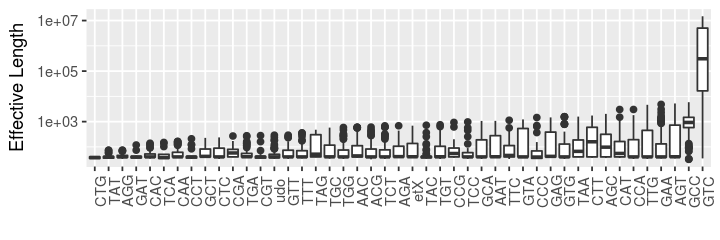

In [24]:
options(repr.plot.width = 6)
options(repr.plot.height = 2)
p8 <- ggplot(results %>% filter(grepl("tRNA",Name))) + 
    geom_boxplot(aes(x = fct_reorder(Isotype,EffectiveLength,fun=max),y = EffectiveLength)) +
        ylab("Effective Length") + xlab("") + scale_y_continuous(trans="log10") +
    theme(axis.text.x = element_text(angle = 90))
p8

In [25]:
elen = results %>% filter(grepl("tRNA",Name)) %>% 
        group_by(Name,Isotype) %>% 
        summarise(x.m=mean(Length),
                y.m=mean(EffectiveLength,na.rm = T),
                 y.s=sd(EffectiveLength,na.rm = T))

Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 200 rows containing missing values (geom_errorbar).”

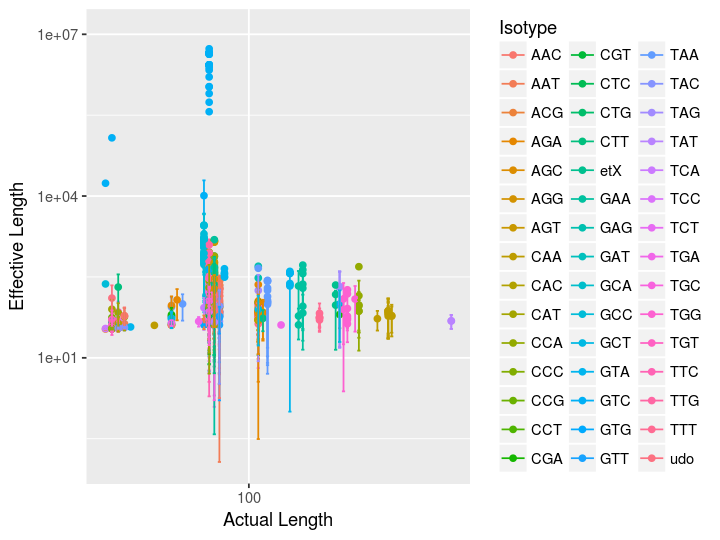

In [26]:
options(repr.plot.width = 6)
options(repr.plot.height = 4.5)
p9 <- ggplot(elen) + 
    geom_point(aes(x = x.m, y = y.m, color=Isotype)) +
    geom_errorbar(aes(x=x.m, ymax = y.m+y.s, ymin = y.m-y.s,color=Isotype )) +
    ylab("Effective Length") + xlab("Actual Length") + scale_y_continuous(trans="log10") +
    scale_x_continuous(trans="log10")
p9

In [33]:
results %>% filter(grepl("tRNA",Name)) %>% arrange(-EffectiveLength) %>% head(5)

Name.original,Name,AA,Isotype,Isotype.Number,origin,Length,EffectiveLength,TPM,NumReads,⋯,qval,rss,sigma_sq,tech_var,mean_obs,var_obs,sigma_sq_pmax,smooth_sigma_sq,final_sigma_sq,degrees_free
SYN.chr18.tRNA17-AspGTC,chr18.tRNA17-AspGTC,Asp,GTC,,SYN,92,14807624,0.000432,551.9155,⋯,0.0104991681,9.15285,1.824009,0.006560923,5.279204,1.830570,1.824009,0.4241622,1.824009,3
WT.chr04.tRNA8-AspGTC,chr04.tRNA8-AspGTC,Asp,GTC,,WT,92,10915575,0.000488,459.7945,⋯,0.0007892086,13.64580,2.719478,0.009681663,4.678408,2.729159,2.719478,0.3861272,2.719478,3
SYN.chr18.tRNA4-AspGTC,chr18.tRNA4-AspGTC,Asp,GTC,,SYN,92,10915135,0.000525,494.0294,⋯,0.2138575267,7.83333,1.563246,0.003420373,5.681521,1.566666,1.563246,0.4444362,1.563246,3
WT.chr07.tRNA29-AspGTC,chr07.tRNA29-AspGTC,Asp,GTC,,WT,92,10915024,0.000485,456.7139,⋯,0.0010653863,10.53421,2.097775,0.009067063,4.802815,2.106842,2.097775,0.3877062,2.097775,3
WT.chr10.tRNA5-AspGTC,chr10.tRNA5-AspGTC,Asp,GTC,,WT,92,10914807,0.000480,451.8247,⋯,0.0007892086,16.26502,3.248864,0.004140798,4.500731,3.253004,3.248864,0.3850073,3.248864,3


## TODO

High priority
- Comparison of contaminants
- Properties/diff expression across experiments

Low priority
- Estimate insert sizes
- CCA vs non-CCA populations